In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

current_path = sys.path[0]
sys.path.append(current_path[:current_path.find('defi-measurement')] + "liquidity-distribution-history")

In [14]:
import os
from pool_state import v3Pool
import numpy as np
import matplotlib.pyplot as plt

import json

import pandas as pd
from prisma import Prisma


from dotenv import load_dotenv


load_dotenv(override=True)

True

In [4]:
postgres_uri = os.getenv("POSTGRES_URI")

assert postgres_uri is not None, "Connection string to Postgres is not set"

In [73]:
pool_symbols = json.load(open("../addresses/pool_tokens.json", "r"))

# Take out the 10 first pools of the dictionary
# pool_symbols = {k: pool_symbols[k] for k in list(pool_symbols)[:10]}

In [74]:
client = Prisma()
await client.connect()

print(f"{await client.swap.count():,}")

341,772


In [75]:
swaps_v3 = await client.swap.find_many()
swap_df = pd.DataFrame([swap.dict() for swap in swaps_v3])

# Filter out certain swaps if needed
swap_df.address = swap_df.address.str.lower()

swap_df.amount0 = swap_df.amount0.astype(float)
swap_df.amount1 = swap_df.amount1.astype(float)

print(f"{swap_df.block_number.nunique():,} blocks from {swap_df.block_timestamp.min()} to {swap_df.block_timestamp.max()}")

56,838 blocks from 2023-06-16 22:24:23+00:00 to 2023-06-25 04:11:59+00:00


In [84]:

filtered_df = swap_df[swap_df.address == "0x5777d92f208679db4b9778590fa3cab3ac9e2168"]

print(f"{filtered_df.block_number.nunique():,} blocks from {filtered_df.block_timestamp.min()} to {filtered_df.block_timestamp.max()}")

1,190 blocks from 2023-06-16 22:28:11+00:00 to 2023-06-25 04:00:11+00:00


In [85]:
swapcounts = filtered_df.groupby(['block_number', 'address']).count().transaction_hash.sort_values(ascending=False)

swapcounts.head()

block_number  address                                   
17542788      0x5777d92f208679db4b9778590fa3cab3ac9e2168    3
17551511      0x5777d92f208679db4b9778590fa3cab3ac9e2168    3
17535895      0x5777d92f208679db4b9778590fa3cab3ac9e2168    2
17524809      0x5777d92f208679db4b9778590fa3cab3ac9e2168    2
17526565      0x5777d92f208679db4b9778590fa3cab3ac9e2168    2
Name: transaction_hash, dtype: int64

In [77]:
print(f'More than 3 swaps: {(swapcounts > 3).sum():,} / {swapcounts.shape[0]:,} ({(swapcounts > 3).sum() / swapcounts.shape[0]:.2%})')
print(f'More than 4 swaps: {(swapcounts > 4).sum():,} / {swapcounts.shape[0]:,} ({(swapcounts > 4).sum() / swapcounts.shape[0]:.2%})')

More than 3 swaps: 4,623 / 281,369 (1.64%)
More than 4 swaps: 2,130 / 281,369 (0.76%)


In [86]:
# pool_address = "0x5777d92f208679db4b9778590fa3cab3ac9e2168"
# block_number = 17_500_000

# Start with block and pool with the most swaps
block_number = int(swapcounts.index.get_level_values(0).values[0])
pool_address = str(swapcounts.index.get_level_values(1)[0])


In [87]:

pool_info = pool_symbols[pool_address]
swap_block = filtered_df[(filtered_df.block_number == block_number) & (filtered_df.address == pool_address)]

print(f'{swap_block.shape[0]:,} swaps in block {block_number:,} for pool {pool_info["name"]}')

tokens = [pool_info['token0'], pool_info['token1']]

swap_block.head()

3 swaps in block 17,542,788 for pool DAI-USDC


,transaction_hash,block_timestamp,block_number,transaction_index,log_index,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,address,from_address,to_address,from_mempool
45830,0xf1d01d7db0dddefee82a52673953f50e9546237e4fb9...,2023-06-23 14:13:23+00:00,17542788,0,3,0xDef1C0ded9bec7F1a1670819833240f027b25EfF,0x1231DEB6f5749EF6cE6943a275A1D3E7486F4EaE,-2.468736e+22,2.468897e+10,79226782781262163655244,534054320675063789444239,-276325,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0xDef1C0ded9bec7F1a1670819833240f027b25EfF,0x1231DEB6f5749EF6cE6943a275A1D3E7486F4EaE,False
45831,0x62d0d9b120c260ebd44bd674307c9b94817675766d1f...,2023-06-23 14:13:23+00:00,17542788,1,22,0x2d2A7d56773ae7d5c7b9f1B57f7Be05039447B4D,0x2d2A7d56773ae7d5c7b9f1B57f7Be05039447B4D,1.316008e+21,-1.315831e+09,79226782586055734981739,534054320675063789444239,-276325,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0x2d2A7d56773ae7d5c7b9f1B57f7Be05039447B4D,0x2d2A7d56773ae7d5c7b9f1B57f7Be05039447B4D,False
45840,0x0017747a1676630718b77fdc9981911da77714692639...,2023-06-23 14:13:23+00:00,17542788,38,178,0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD,0xBfEbCaf188D023964F2B66Fc1d2394E43776A1F6,-1.866270e+23,1.866392e+11,79226810271637180086716,534054320675063789444239,-276325,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD,0xBfEbCaf188D023964F2B66Fc1d2394E43776A1F6,True


### 1. Historical Liquidity Distribution / Market Depth
* Useful when investors want to manually investigate liquidity distribution in history
* Current implementation: 
    - Input: as_of (can be intra-block)
    - Output: liquidity at each tick
* Quick iteration:
    - Input: time_range, frequency
    - Output: dataframe of liquidity distribution at each point in time + gif displaying liquidity dynamics


In [88]:
print(f"""
pool_add              = "{pool_address}"  # {pool_symbols[pool_address]['name']}
block_number          = {block_number:_}
""")


pool_add              = "0x5777d92f208679db4b9778590fa3cab3ac9e2168"  # DAI-USDC
block_number          = 17_542_788



In [89]:
%%time
########### INPUT BLOCK ###############
transaction_index     = 0
#######################################

as_of = block_number + transaction_index / 1e4
# pool = v3Pool(pool_address, initialize=False, database_url=postgres_uri)
pool = v3Pool(
    pool_address,
    connStr=postgres_uri,
    initialize=True,
    load_data=True,
    update=True,
)

x, y = pool.createLiq(as_of)
x, y = np.array(x), np.array(y)
price = pool.getPriceAt(as_of)

Establishing schema
Updating factory
Updating from V3Factory_PoolCreated for 0x5777d92f208679db4b9778590fa3cab3ac9e2168
Nothing to update for factory above block 17495411
Updating block_info
Updating from ethereum_block_heuristics for 0x5777d92f208679db4b9778590fa3cab3ac9e2168
Nothing to update for block_info above block 17571702
Updating initialize
Updating from ethereum_uniswap_v3_pool_evt_initialize for 0x5777d92f208679db4b9778590fa3cab3ac9e2168
Nothing to update for initialize above block 17495411
Filling mb
Selecting from MintBurnV3-labeled
Selecting as-of 17575597 block
Inserting mintburn into database
Inserting chunk number 0 of size 500000.0
Updating collects
Updating from collect_all for 0x5777d92f208679db4b9778590fa3cab3ac9e2168
Nothing to update for collects above block 17533607
Filling swaps
Selecting from swap
Inserting swaps into database
Inserting chunk number 0 of size 500000.0


/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:496: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  swaps = pd.read_sql(q, self.conn)
/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:512: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mb = pd.read_sql(q, self.conn)
/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:544: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  block_info = pd.read_sql(q, self.conn)
/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:

Initializing liquidity
CPU times: user 34.2 s, sys: 35.7 s, total: 1min 9s
Wall time: 7min 17s


Price range: 0.9990 - 1.0010


Text(0.5, 1.0, 'Liquidity Distribution as of block number 17542788.0')

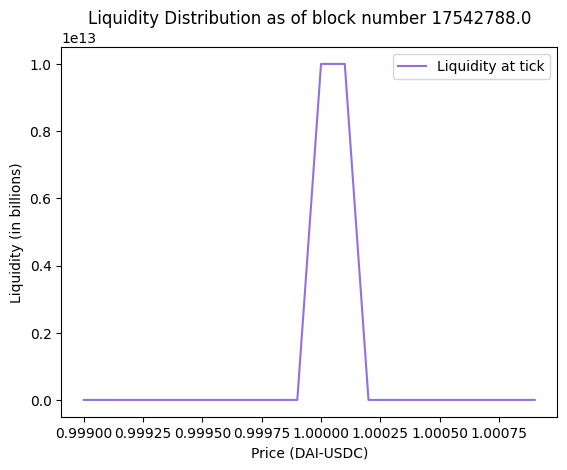

In [98]:

liq_df = pd.DataFrame(x, columns=["ticks"])
liq_df["liquidity"] = y
liq_df['px'] = 1 / (1.0001 ** liq_df['ticks'])

display_price_lower   = 0.999
display_price_upper   = 1.001

# Find upper and lower price bounds

liq_df = liq_df.set_index("px").sort_index()
# liq_df = liq_df.assign(cum_liq=liq_df.liquidity.cumsum())

# total_liq = liq_df.liquidity.sum()

# liq_df = liq_df.assign(cum_liq_pct=liq_df.cum_liq / total_liq)

# liq_95 = liq_df[(liq_df.cum_liq_pct > 0.025) & (liq_df.cum_liq_pct < 0.975)]

# display_price_lower = liq_95.index.min()
# display_price_upper = liq_95.index.max()

print(f"Price range: {display_price_lower:.4f} - {display_price_upper:.4f}")

plot_df = liq_df[(liq_df.index < display_price_upper) & (liq_df.index > display_price_lower)]
# plot_df = liq_df  # .set_index("px")

fig, ax = plt.subplots()

ax.plot(plot_df['liquidity'], label="Liquidity at tick", color='mediumpurple')
# ax.axvline(price, color = 'black', linestyle = "--")
ax.legend()
ax.set_ylabel("Liquidity (in billions)")
ax.set_xlabel(f"Price ({pool_symbols[pool_address]['name']})")
ax.set_title('Liquidity Distribution as of block number {}'.format(as_of))

KeyError: "None of ['px'] are in the columns"

In [ ]:

# get min and max tick
%%time
########### INPUT BLOCK ###############


swapParams            = {'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
                         'input': 1.26241e+21,
                         'gasFee': True,
                         'as_of': block_number + transaction_index / 1e4}
    
swaps_params = []

for i, (amount0, amount1) in swap_block[['amount0', 'amount1']].iterrows():
    if amount0 > 0:
        amount_in = amount0
        token_in = tokens[0]
    else:
        amount_in = amount1
        token_in = tokens[1]

    swaps_params.append({'tokenIn': token_in, 'input': amount_in, 'gasFee': True})


#######################################

pool = v3Pool(
    pool_address=pool_address,
    database_url=postgres_uri,
    initialize=False,
)

block_results = []

sqrt_P = pool.getPriceAt(block_number)

for i, swap_param in enumerate(swaps_params):
    output, heur = pool.swapIn({**swap_param, 'as_of': block_number + i / 1e4, 'givenPrice': sqrt_P})

    summ = {
        'total_output': output,
        'totalFee': heur[0],
        'crossed_ticks': heur[1], 
        'liquidity_in_range': heur[2], 
        'sqrt_P': heur[3], 
        'sqrtP_next': heur[4], 
        'inRangeTest': heur[5], 
        'swapInMinusFee': heur[6], 
        'zeroForOne': heur[7], 
        'gas_fee': heur[8]
    }

    sqrt_P = heur[3]

    block_results.append({
        'output': output,
        **summ,
    })

print('tx details summary: ')
print(pd.Series(summ).to_string())

## Test the baseline case with Liquidity for USD/ETH 0.3%

In [111]:
def plot_liquidity(pool_add, block_number, transaction_index, display_price_lower, display_price_upper, initialize=False):
    as_of = block_number + transaction_index / 1e4
    pool = v3Pool(pool_add, initialize=initialize, connStr=postgres_uri)
    x, y = pool.createLiq(as_of)
    x, y = np.array(x), np.array(y)
    px = pool.getPriceAt(as_of)
    liq_df = pd.DataFrame(x, columns=["ticks"])
    liq_df["liquidity"] = y
    liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12  # \sqrt{P} \cdot x = L ???

    plot_df = liq_df[(liq_df['px'] < display_price_upper) & (liq_df['px'] > display_price_lower)].set_index("px")

    fig, ax = plt.subplots()

    ax.plot(plot_df['liquidity'], label = "Liquidity at tick", color = 'mediumpurple')
    ax.axvline((1 / px ** 2) * 1e12, color = 'black', linestyle = "--")
    ax.legend()
    ax.set_ylabel("Liquidity (in billions)")
    ax.set_xlabel("Price (USDC/ETH)")
    ax.set_title(f'Liquidity Distribution as of block number {int(as_of)}')

    # Make the x-axis be logarithmic
    ax.set_xscale('log')

/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:477: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  swaps = pd.read_sql(q, self.conn)
/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:493: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mb = pd.read_sql(q, self.conn)
/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:524: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  block_info = pd.read_sql(q, self.conn)
/Users/larsankile/Code/liquidity-distribution-history/pool_state.py:

Initializing liquidity
CPU times: user 25.7 s, sys: 24 s, total: 49.7 s
Wall time: 2min 51s


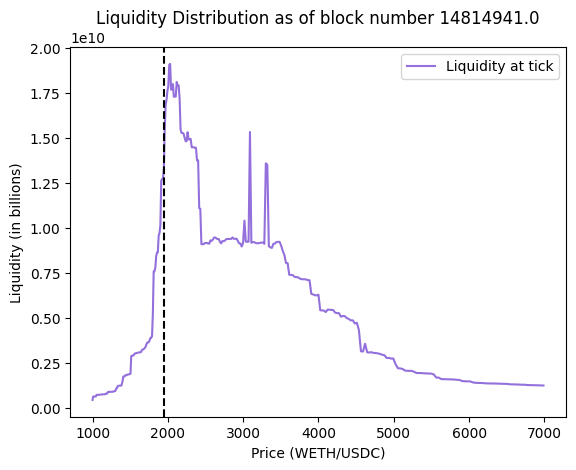

In [102]:
%%time
########### INPUT BLOCK ###############

pool_add              = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
block_number          = 14814941
transaction_index     = 0
display_price_lower   = 1000
display_price_upper   = 7000

#######################################

plot_liquidity(pool_add, block_number, transaction_index, display_price_lower, display_price_upper)
